# Loss functions and gradients in algorithmic recourse

This is a short tutorial on gradients typically involved in optimization problems of algorithmic recourse.

In [65]:
using Zygote
using Plots
using PlotThemes
theme(:juno)
using LinearAlgebra

## General setup

Let $t\in\{0,1\}$ denote the target label, $f\in\{0,1\}$ the predicted label and $x'\in\mathbb{R}^D$ the vector of counterfactual features. Then the differentiable optimization problem in algorithmic recourse is generally of the following form

$$
x' = \arg \min_{x'} \max _{\lambda} \lambda \ell(f(x'),t) + h(x')
$$

where $\ell$ denotes some loss function targeting the deviation between the target label and the predicted label and $h(\cdot)$ as a complexity penality generally addressing the *realism* or *cost* of the proposed counterfactual. 

## Loss function $\ell$

Different choices for $\ell$ come to mind, each potentially leading to very different counterfactual outcomes. In practice, $\ell$ is typically implemented with respect to the *logits* $a=\mathbf{w}^Tx$ rather than the probabilities $p(y'=1|x')=\sigma(a)$ predicted by the classifier . We follow this convention here. Common choices for $\ell$ in the literature have included *Hinge* loss, *cross-entropy* (or *log*) loss or *mean squared error* loss (MSE). We shall look at these in some more details here.

### Hinge loss

With respect to the logits $a=\mathbf{w}'x$ Hinge loss can be defined as follows

$$
\ell(a,t)=(t-a)_+=\max\{0,t-a\}
$$

where $t$ is the target class in as before (we have $t\in\{0,1\}$ for a binary classification problem).

**NOTE**: Hinge loss is generally defined for the target domain $\{-1,1\}$. Therefore in our context we have $a=z \mathbf{w}^Tx'$ where 

$$
\begin{aligned}
z&=\begin{cases}
-1 && \text{if} && f=0 \\ f && \text{if} && f=1
\end{cases}
\end{aligned}
$$

The first-order derivative of Hinge loss with respect to the logits $a$ is simply

$$
\begin{aligned}
\ell'(a,t)&=\begin{cases}
-1 && \text{if} && a<=1 \\ 0 && \text{otherwise.} 
\end{cases}
\end{aligned}
$$

In the context of counterfactual search the gradient with respect to the feature vector is as follows:

$$
\begin{aligned}
&& \nabla_{x'} \ell(a,t)&= \begin{cases}
-z\mathbf{w} && \text{if} && z\mathbf{w}^Tx'<=1 \\ 0 && \text{otherwise.} 
\end{cases}
\end{aligned}
$$

In practice gradients are commonly computed through autodifferentiation. In this tutorial we use the [Zygote.jl](https://github.com/FluxML/Zygote.jl) package which is at the core of [Flux.jl](https://fluxml.ai/Flux.jl/stable/models/basics/), the main deep learning package for Julia.

The side-by-side plot below visualises the loss function and its derivative. The plot further below serves as a simple sanity check to verify that autodifferentiation indeed yields the same result as the closed-form solution for the gradient.

In [41]:
hinge(a,t) = max(0,t-a)

hinge (generic function with 1 method)

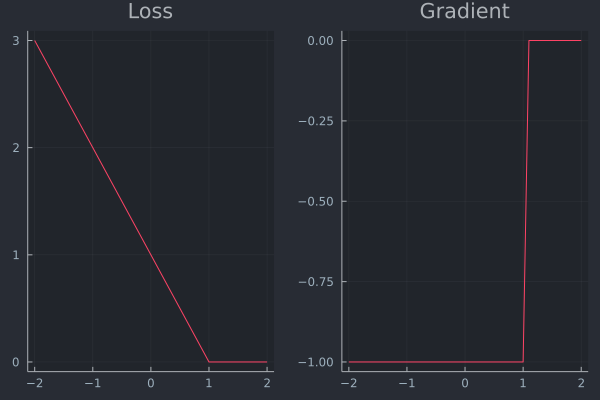

In [42]:
a = -2:0.1:2
p1 = plot(a, [hinge(a,1) for a=a], title="Loss")
p2 = plot(a, [gradient(hinge,a,1)[1] for a=a], title="Gradient")
plot(p1, p2, layout = (1, 2), legend = false)

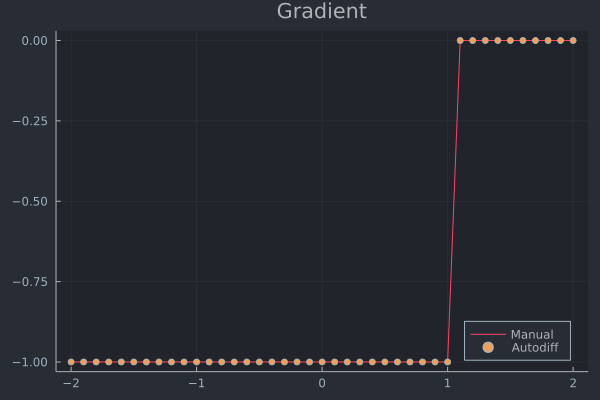

In [63]:
# Just verifying that the formula for the gradient above indeed yields the same result.
function gradient_man(x,w,y)
    𝐠 = ifelse(w'x<=1, -w, 0)
    return 𝐠
end;
plot(a, [gradient_man(a,1,1) for a=a], legend=:bottomright, label="Manual", title="Gradient")
scatter!(a, [gradient(hinge,a,1)[1] for a=a], label="Autodiff")

### Cross-entropy loss (binary)

Binary cross-entropy loss or log loss is typically defined as follows:

$$
\begin{aligned}
&& \ell(a,t)&=- \left( t \cdot \log(\sigma(a)) + (1-t) \cdot \log (1-\sigma(a)) \right) \\
\end{aligned}
$$

where $\sigma(a)$ is the logit function.

Once again for the purpose of counter factual search we are interested in the first-order derivative with respect to our feature vector $x'$. You can verify that the partial derivative with respect to feature $x'_d$ is as follows:

$$
\begin{aligned}
&& \frac{\partial \ell(a,t)}{\partial x'_d}&= (\sigma(a) - t) w_d \\
\end{aligned}
$$

The gradient just corresponds to the stacked vector of partial derivatives:

$$
\begin{aligned}
&& \nabla_{x'} \ell(a,t)&= (\sigma(a) - t) \mathbf{w} \\
\end{aligned}
$$

As before implementation below is done through autodifferentiation. As before the side-by-side plot shows the resulting loss function and its gradient and the plot further below is a simple sanity check.

In [43]:
# logit function:
function 𝛔(a)
    trunc = 8.0 # truncation to avoid numerical over/underflow
    a = clamp.(a,-trunc,trunc)
    p = exp.(a)
    p = p ./ (1 .+ p)
    return p
end

# Binary crossentropy:
crossentropy(a, t) = - (t * log(𝛔(a)) + (1-t) * log(1-𝛔(a)))

crossentropy (generic function with 1 method)

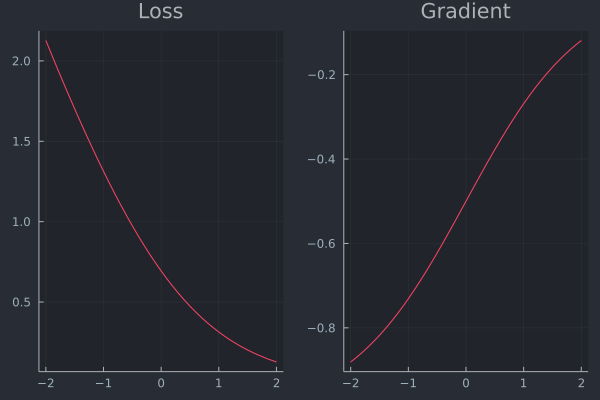

In [44]:
p1 = plot(a, [crossentropy(a,1) for a=a], title="Loss")
p2 = plot(a, [gradient(crossentropy,a,1)[1] for a=a], title="Gradient")
plot(p1, p2, layout = (1, 2), legend = false)

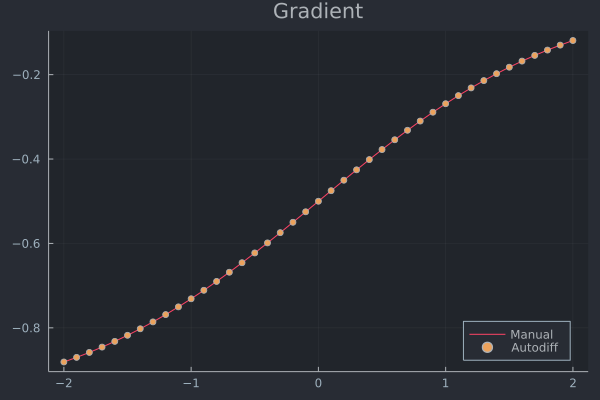

In [50]:
# Just verifying that the formula for the gradient above indeed yields the same result.
function gradient_man(x,w,y)
    𝐠 = (𝛔(w'x) - y) .* w
    return 𝐠
end;
plot(a, [gradient_man(a,1,1) for a=a], legend=:bottomright, label="Manual", title="Gradient")
scatter!(a, [gradient(crossentropy,a,1)[1] for a=a], label="Autodiff")

### Mean squared error

Some authors work with distance-based loss functions instead. Since in general we are interested in providing valid recourse, that is counterfactual explanations that indeed lead to the desired label switch, using one of the margin-based loss functions introduced above seems like a more natural choice. Nonetheless, we shall briefly introduce one of the common distance-based loss functions as well. 

The mean squared error for counterfactual search implemented with respect to the logits is simply the squared $\ell 2$ distance between the target label and $a=\mathbf{w}^Tx$:

$$
\begin{aligned}
&& \ell(a,t)&= ||t-a||^2
\end{aligned}
$$

The gradient with respect to the vector of features is then:

$$
\begin{aligned}
&& \nabla_{x'} \ell(a,t)&= 2(a - t) \mathbf{w} \\
\end{aligned}
$$

As before implementation and visualizations follow below.

In [52]:
mse(a,t) = norm(t - a)^2

mse (generic function with 1 method)

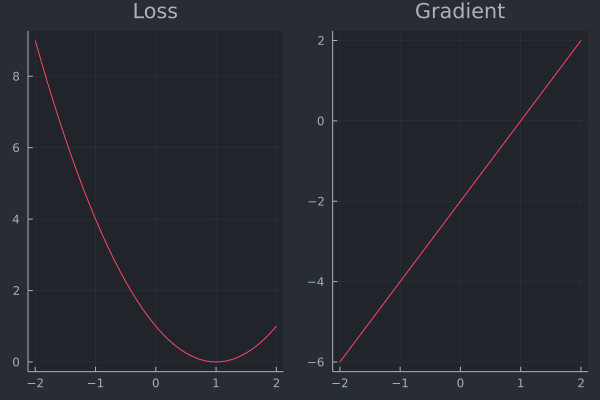

In [58]:
p1 = plot(a, [mse(a,1) for a=a], title="Loss")
p2 = plot(a, [gradient(mse,a,1)[1] for a=a], title="Gradient")
plot(p1, p2, layout = (1, 2), legend = false)

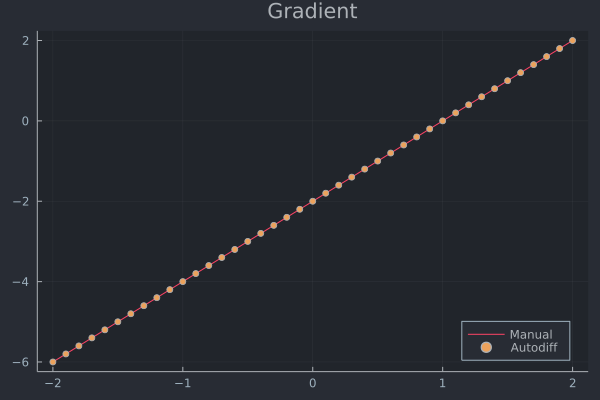

In [61]:
# Just verifying that the formula for the gradient above indeed yields the same result.
function gradient_man(x,w,y)
    𝐠 = 2*(w'x - y) .* w
    return 𝐠
end;
plot(a, [gradient_man(a,1,1) for a=a], legend=:bottomright, label="Manual", title="Gradient")
scatter!(a, [gradient(mse,a,1)[1] for a=a], label="Autodiff")

## Example in 2D

To understand the properties of the different loss functions we will now look at a tow example in 2D. The code below generates some random features and assigns labels based on a fixed vector of coefficients using the sigmoid function.

In [118]:
# Some random data:
using Random
Random.seed!(1234);
N = 25
w = [1,-2] # true coefficients
X = reshape(randn(2*N),N,2) # random features
y = Int.(round.(𝛔(X*w))); # label based on sigmoid

The plot below shows the samples coloured by label along with the decision boundary. You can think of this as representing the outcome of some automated decision making system. The highlighted sample was chosen to receive algorithmic recourse in the following: we will search for a counterfactual that leads to a label switch.

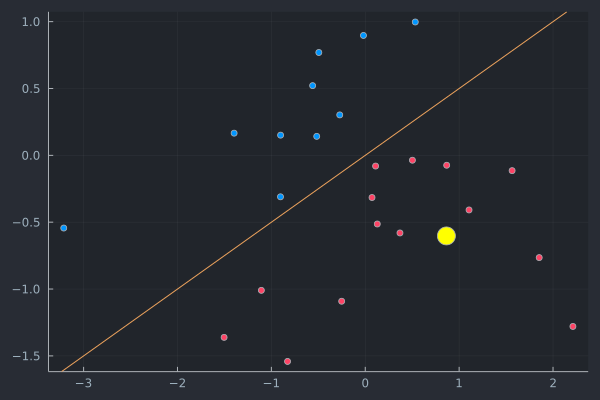

In [120]:
# Plot with random sample chose for recourse
x_prime = X[5,:]
scatter(X[:,1],X[:,2],legend=false,color=y) # features
Plots.abline!(-w[1]/w[2],0) # decision boundary
scatter!([x_prime[1]],[x_prime[2]],color="yellow",markersize=10)

In [ ]:
# Generate recourse: